## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [87]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-02-27 21:16:21--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.2’

ml-1m.zip.2         100%[===================>]   5.64M  4.28MB/s    in 1.3s    

2025-02-27 21:16:23 (4.28 MB/s) - ‘ml-1m.zip.2’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for

In [1]:
import pandas as pd
import numpy as np
from typing import Union

In [2]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [3]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [4]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [5]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [6]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [7]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 787420 entries, 100409 to 1000208
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   787420 non-null  int64         
 1   item_id   787420 non-null  int64         
 2   rating    787420 non-null  int64         
 3   datetime  787420 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 30.0 MB


##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [9]:
df_train.head()

,user_id,item_id,rating,datetime
100409,0,2994,3,2000-11-30 23:49:23
100411,0,929,4,2000-11-30 23:52:33
100412,0,567,4,2000-11-30 23:51:54
100415,0,3005,1,2000-11-30 23:58:06
100416,0,3006,4,2000-11-30 23:57:50


In [28]:
def df_to_matrix(frame: pd.DataFrame, rating_name='rating') -> np.ndarray:

    n_users = frame['user_id'].nunique()
    n_items = frame['item_id'].nunique()

    result = np.zeros((n_users, n_items))
    
    for _, row in frame.iterrows():
        result[row['user_id'], row['item_id']] = row[rating_name]
    return result

In [11]:
interactions = df_to_matrix(df_train)

In [12]:
from scipy.sparse import coo_array

def df_to_coo(frame: pd.DataFrame) -> coo_array:

    user_map = {user_id: idx for idx, user_id in enumerate(frame['user_id'].unique())}
    item_map = {item_id: idx for idx, item_id in enumerate(frame['item_id'].unique())}
    row_indices = frame['user_id'].map(user_map).values
    col_indices = frame['item_id'].values
    data = frame['rating'].values

    result = coo_array((data, (row_indices, col_indices)), shape=(len(user_map), len(item_map)))
    
    return result

In [13]:
coo_interactions = df_to_coo(df_train)

In [14]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [20]:
import numpy as np
from scipy.sparse.linalg import svds

def make_svd(interactions: np.ndarray | coo_array, n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)
    U, S, Vt = 0, 0, 0

    if isinstance(interactions, np.ndarray):
        if n_singular_values == -1:
            U, S, Vt = np.linalg.svd(interactions, full_matrices=False)
        else:
            U, S, Vt = np.linalg.svd(interactions, full_matrices=False)
            U, S, Vt = U[:, :n_singular_values], S[:n_singular_values], Vt[:n_singular_values]
    elif isinstance(interactions, coo_array):
        if n_singular_values == -1:
            n_singular_values = interactions.shape[1] - 1
        
        U, S, Vt = svds(interactions, k=n_singular_values)
    return U, np.diag(S), Vt

In [102]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ (S @ V), interactions)

In [106]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ (S1 @ V1), U @ (S @ V))

In [107]:
U1.shape, S1.shape, V1.shape

((5365, 10), (10, 10), (10, 3010))

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [16]:
def make_svd_recommendations(interractions: np.ndarray | coo_array, n_singular_values: int = -1, top_k: int = 100):
    U, S, V = make_svd(interractions, n_singular_values)
    predicted_ratings = U @ S @ V 

    recommendations = []
    n_users, n_items = predicted_ratings.shape

    for user_index in range(n_users):
        if isinstance(interractions, np.ndarray):
            user_interactions = interractions[user_index]  
        else:
            user_interactions = interractions[user_index, :].toarray()

        user_scores = predicted_ratings[user_index]
        # user_scores[user_interactions.nonzero()[1]] = -np.inf  

        top_k_indices = np.argsort(user_scores)[-top_k:][::-1] 
        recommendations.append(top_k_indices)

    return np.array(recommendations)

In [111]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [17]:
from sklearn.metrics import ndcg_score

def evaluate_recommendations(interactions:  np.ndarray | coo_array, recommendations: np.ndarray, top_k) -> float:
    n_users, n_items = interactions.shape
    total_ndcg = 0.0 

    for user_index in range(n_users):
        relevant_items = interactions[user_index].nonzero()[0]
        
        y_true = np.zeros(n_items)  
        y_true[relevant_items] = 1 
        
        recommended_items = recommendations[user_index][:top_k]  
        
        y_scores = np.zeros(n_items)  
        y_scores[recommended_items] = 1  
        
        ndcg = ndcg_score([y_true], [y_scores])
        total_ndcg += ndcg

    return total_ndcg / n_users

In [129]:
import matplotlib.pyplot as plt


def plot_graphs(interractions: np.ndarray | coo_array, top_k: int = 100) -> tuple[list, list]:
    results = []

    n_singular_values_list = [1, 10, 50, 200, 1000]

    for n_singular_values in n_singular_values_list:
        recommendations = make_svd_recommendations(interractions, n_singular_values=n_singular_values, top_k=top_k)
        
        metric = evaluate_recommendations(interractions, recommendations, top_k)
        results.append(metric)
    return n_singular_values_list, results

n_singular_values_list, results = plot_graphs(interactions)
 

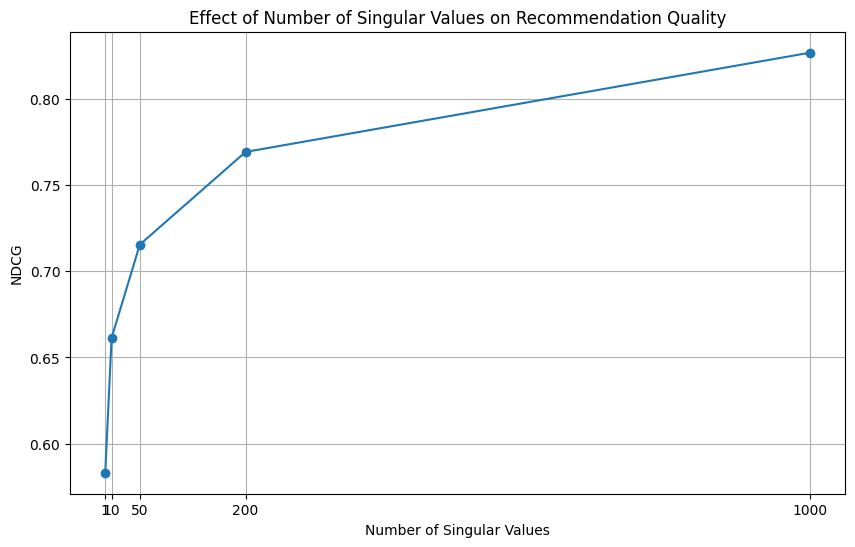

In [131]:
plt.figure(figsize=(10, 6))
plt.plot(n_singular_values_list, results, marker='o')
plt.xticks(n_singular_values_list)
plt.title('Effect of Number of Singular Values on Recommendation Quality')
plt.xlabel('Number of Singular Values')
plt.ylabel('NDCG')
plt.grid()
plt.show()

In [135]:
print(f'Max NDCG: {max(results)}')

Max NDCG: 0.8267400348951607


##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [18]:
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
from implicit.als import AlternatingLeastSquares
from typing import Union

def make_als_recommendations(
    interactions: Union[np.ndarray, coo_matrix], 
    top_k: int = 100, 
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
) -> np.ndarray:
    if isinstance(interactions, np.ndarray):
        interactions = csr_matrix(interactions)

    model = AlternatingLeastSquares(factors=n_factors, 
                                    regularization=regularization, 
                                    alpha=alpha, 
                                    iterations=20)
    
    model.fit(interactions)

    user_factors = model.user_factors
    item_factors = model.item_factors

    scores = np.dot(user_factors, item_factors.T)

    recommendations = np.zeros((scores.shape[0], top_k), dtype=int)

    for user_index in range(scores.shape[0]):
        recommended_indices = np.argsort(scores[user_index])[::-1][:top_k]
        recommendations[user_index] = recommended_indices

    return recommendations

In [16]:
recs = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

/Users/akovel/anaconda3/envs/HSE/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
best_ndcg = -1
best_params = {}

for n_factors in [20, 50, 100]:
    for alpha in [1.0, 5.0, 10.0]:
        for regularization in [0.01, 0.1, 1.0]:
            recommendations = make_als_recommendations(interactions, top_k=100, n_factors=n_factors, alpha=alpha, regularization=regularization)
            
            ndcg = evaluate_recommendations(interactions, recommendations, top_k=100)
            
            print(f'n_factors: {n_factors}, alpha: {alpha}, regularization: {regularization}, NDCG: {ndcg}')
            
            if ndcg > best_ndcg:
                best_ndcg = ndcg
                best_params = {'n_factors': n_factors, 'alpha': alpha, 'regularization': regularization}

In [20]:
print(f'Best params: {best_params}, Best NDCG: {best_ndcg}')

Best params: {'n_factors': 100, 'alpha': 5.0, 'regularization': 0.01}, Best NDCG: 0.7606340105720808


In [23]:
best_params = {'n_factors': 100, 'alpha': 5.0, 'regularization': 0.01} 

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [46]:
model = AlternatingLeastSquares(factors=100, 
                                regularization=0.01, 
                                alpha=5.0, 
                                iterations=20)

model.fit(csr_matrix(interactions))

  0%|          | 0/20 [00:00<?, ?it/s]

In [139]:
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
from implicit.als import AlternatingLeastSquares

def make_als_recommendations_and_explanations(
    interactions: Union[np.ndarray, coo_matrix], 
    movie_titles: dict,
    user_ids: list, 
    model: AlternatingLeastSquares,
    top_k: int = 5
):
    if isinstance(interactions, np.ndarray):
        interactions = csr_matrix(interactions)

    recommend = {}
    explanation = {}

    for user_id in user_ids:
        recs = model.recommend(user_id, interactions[user_id], N=top_k)
        for i, _ in enumerate(recs[0]):
            item, score = recs[0][i], recs[1][i] 
            explanations = model.explain(user_id, interactions[user_id], item, N=top_k)
            recommend[user_id] = movie_titles["movie_name"][movie_titles["id"] == item]
            print(f" - {movie_titles['movie_name'][movie_titles['id'] == item]}: {explanations[0]:.4f}")

    return recommend, explanation

In [134]:
movies = pd.read_csv("ml-1m/movies.dat", sep='::', names=['id', 'movie_name', 'genre'], engine='python')

In [135]:
movies[(movies["id"] == 670)]

,id,movie_name,genre
664,670,"World of Apu, The (Apur Sansar) (1959)",Drama


In [141]:
user_ids = [0]  
print(f"\nRecommendations for User {user_id}:")

recommendations, explanations = make_als_recommendations_and_explanations(
    interactions, 
    movies, 
    user_ids, 
    model
)


Recommendations for User 0:
 - 664    World of Apu, The (Apur Sansar) (1959)
Name: movie_name, dtype: object: 1.2053
 - 932    Lost Horizon (1937)
Name: movie_name, dtype: object: 1.0482
 - 913    Golden Earrings (1947)
Name: movie_name, dtype: object: 1.0013
 - 495    Mr. Wonderful (1993)
Name: movie_name, dtype: object: 1.0067
 - 576    Princess Caraboo (1994)
Name: movie_name, dtype: object: 0.9943


##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [ ]:
df_train['bin_var'] = np.where(df_train['rating'] > 0, 1, 0)
interations_bin = df_to_matrix(df_train)

svd_recs_bin = make_svd_recommendations(interations_bin, n_singular_values=10)
als_recs_bin = make_als_recommendations(interations_bin, **best_params)

In [27]:
print(f'NDCG@10 als: {evaluate_recommendations(interations_bin, als_recs_bin, top_k=10)}')
print(f'NDCG@10 svd: {evaluate_recommendations(interations_bin, svd_recs_bin, top_k=10)}')

NDCG@10 als: 0.6325836586577912
NDCG@10 svd: 0.5980653837377388


In [29]:
df_train['bin_var'] = np.where(df_train['rating'] >= 4, 1, 0)

interations_bin = df_to_matrix(df_train, 'bin_var')

svd_recs_bin = make_svd_recommendations(interations_bin, n_singular_values=10)
als_recs_bin = make_als_recommendations(interations_bin, **best_params)

  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
print(f'NDCG@10 als: {evaluate_recommendations(interations_bin, als_recs_bin, top_k=10)}')
print(f'NDCG@10 svd: {evaluate_recommendations(interations_bin, svd_recs_bin, top_k=10)}')

NDCG@10 als: 0.6674125560442911
NDCG@10 svd: 0.5622880056598005


In [31]:
df_train['bin_var'] = np.where(df_train['rating'] >= 4, 1, -1)

interations_bin = df_to_matrix(df_train, 'bin_var')

svd_recs_bin = make_svd_recommendations(interations_bin, n_singular_values=10)
als_recs_bin = make_als_recommendations(interations_bin, **best_params)

print(f'NDCG@10 als: {evaluate_recommendations(interations_bin, als_recs_bin, top_k=10)}')
print(f'NDCG@10 svd: {evaluate_recommendations(interations_bin, svd_recs_bin, top_k=10)}')

  0%|          | 0/20 [00:00<?, ?it/s]

NDCG@10 als: 0.6651009033666933
NDCG@10 svd: 0.57775487466515


In [32]:
df_train['bin_var'] = np.where(df_train['rating'] >= 4, 1, -1)
max_date = df_train['datetime'].max()
df_train['days_diff'] = (max_date - df_train['datetime']).dt.days
decay = 0.9
df_train['time_weight'] = decay ** (df_train['days_diff'] / 30)
df_train['bin_var_decay'] = df_train['bin_var'] * df_train['time_weight']

interations_bin = df_to_matrix(df_train, 'bin_var_decay')

In [33]:
svd_recs_bin = make_svd_recommendations(interations_bin, n_singular_values=10)
als_recs_bin = make_als_recommendations(interations_bin, **best_params)

  0%|          | 0/20 [00:00<?, ?it/s]

In [34]:
print(f'NDCG@10 als: {evaluate_recommendations(interations_bin, als_recs_bin, top_k=10)}')
print(f'NDCG@10 svd: {evaluate_recommendations(interations_bin, svd_recs_bin, top_k=10)}')

NDCG@10 als: 0.6669272279445712
NDCG@10 svd: 0.5776438170465412


##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [35]:
import numpy as np

class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef: float = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.user_factors = None
        self.item_factors = None

    def fit(self, interactions: np.ndarray, n_iterations: int = 10):
        n_users, n_items = interactions.shape
        self.user_factors = np.random.rand(n_users, self.n_factors)
        self.item_factors = np.random.rand(n_items, self.n_factors)

        confidence = interactions * self.alpha
        confidence += (interactions == 0) 

        for _ in range(n_iterations):
            for u in range(n_users):
                item_indices = np.nonzero(interactions[u])[0] 
                if len(item_indices) > 0:
                    A = np.dot(self.item_factors[item_indices].T, self.item_factors[item_indices]) + \
                        self.reg_coef * np.eye(self.n_factors)
                    b = np.dot(confidence[u, item_indices], self.item_factors[item_indices])
                    self.user_factors[u] = np.linalg.solve(A, b)

            for i in range(n_items):
                user_indices = np.nonzero(interactions[:, i])[0]  
                if len(user_indices) > 0:
                    A = np.dot(self.user_factors[user_indices].T, self.user_factors[user_indices]) + \
                        self.reg_coef * np.eye(self.n_factors)
                    b = np.dot(confidence[user_indices, i], self.user_factors[user_indices])
                    self.item_factors[i] = np.linalg.solve(A, b)

    def predict(self, user_interactions: np.ndarray, top_k: int = 100):
        scores = np.dot(self.user_factors, self.item_factors.T)
        scores[user_interactions > 0] = -np.inf
        top_k_items = np.argsort(scores, axis=1)[:, -top_k:]

        return top_k_items  



In [36]:
model = iALS(n_factors=10, alpha=1.0, reg_coef=0.05)
model.fit(interations_bin, n_iterations=10)
predictions = model.predict(interations_bin, top_k=3)

print("Top-k recommendations for each user:")
print(predictions)

Top-k recommendations for each user:
[[1967 2414 2100]
 [1952  643 2945]
 [ 536 1621 1017]
 ...
 [1670  618  612]
 [2494 1872 1412]
 [1163 2898  532]]


In [37]:
print(f'NDCG@10 als: {evaluate_recommendations(interations_bin, predictions, top_k=10)}')

NDCG@10 als: 0.47708721867202164
